**The National Longitudinal Study of Adolescent Health (AddHealth)** is a representative school-based survey of adolescents in grades 7-12 in the United States. The Wave 1 survey focuses on factors that may influence adolescents’ health and risk behaviors, including personal traits, families, friendships, romantic relationships, peer groups, schools, neighborhoods, and communities

**Question**: Does the frequency of exercise relate to the trouble of falling asleep among the adolescents in grades 7-12 in the US?

**Variables**
1. Explanatory variable: The frequency of exercise in the past week (column used: H1DA6). The categorical value is explained below. We will filter out value 6 (refused) and 8 (don't know).

| Value      | Description |
| -----------| -----------|
| 0      | no exercise     |
| 1   | 1 or 2 times       |
| 2   | 3 or 4 times       |
| 3   | 5 or more times    |
| 6   | refused          |
| 8   | don’t know        |

2. Response variable: trouble falling asleep (column used: H1GH18).

    The value in the column H1GH18 is 0 for "never" and 1-4 for "at least once". Therefore for this column, the values 1-4 will be converted to 1 to denote "at least once" for having trouble falling asleep. We also filter out value 6 (refused) and 8 (don't know) for this column.

In [1]:
# Import modules
import pandas as pd
import scipy.stats
import seaborn
import matplotlib.pyplot as plt
import itertools
import statsmodels.stats.multitest as mt

In [2]:
# read and subset the columns of innterest H1TO15 
df = pd.read_csv("../addhealth.csv", low_memory=False)[["H1DA6", "H1GH18"]] \
    .rename(columns={"H1DA6": "exercise_freq", "H1GH18": "trouble_sleep"}) \
    .apply(pd.to_numeric, errors='coerce')
df

,exercise_freq,trouble_sleep
0,3,0
1,0,0
2,0,1
3,2,0
4,0,1
...,...,...
6499,3,1
6500,0,1
6501,2,1
6502,0,1


In [3]:
# subset the rows: we only take values below 5 since 6 is "refused" and 8 is "don't know"
sub = df[["exercise_freq", "trouble_sleep"]]  \
    .loc[lambda r: (r["exercise_freq"] < 5) & (r["trouble_sleep"] < 5)] \
    .dropna() \
    .astype(int)

# The values 1-4 are converted to 1 to denote "at least once" for having trouble falling asleep
sub.loc[sub["trouble_sleep"] >= 1, "trouble_sleep"] = 1
sub

,exercise_freq,trouble_sleep
0,3,0
1,0,0
2,0,1
3,2,0
4,0,1
...,...,...
6499,3,1
6500,0,1
6501,2,1
6502,0,1


In [4]:
# contingency table of observed counts
ct = pd.crosstab(sub["trouble_sleep"], sub['exercise_freq'])
ct

exercise_freq,0,1,2,3
trouble_sleep,,,,
0,467,790,659,790
1,604,1269,959,958


In [5]:
# Column percentages
colpct = ct/ct.sum(axis=0)
colpct

exercise_freq,0,1,2,3
trouble_sleep,,,,
0,0.436041,0.383681,0.407293,0.451945
1,0.563959,0.616319,0.592707,0.548055


/hpc/apps/2018/anaconda3/v5.0.1b.app/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(6.799999999999997, 0.5, 'Proportion of never having trouble falling asleep')

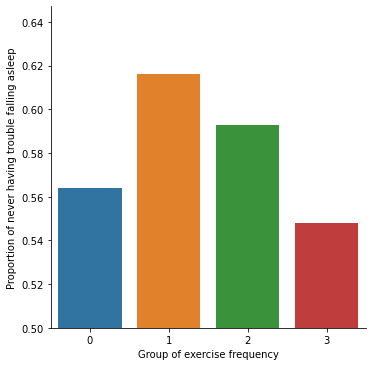

In [6]:
# Using histogram to plot the frequency shown above
seaborn.factorplot(x="exercise_freq", y="trouble_sleep", data=sub, kind="bar", ci=None)
plt.ylim(bottom = 0.5)
plt.xlabel("Group of exercise frequency")
plt.ylabel("Proportion of never having trouble falling asleep")

### Chi-square analysis

From the frequency table above, it seems that adolescents who exercise 1 or 2 times a week (group 1) has less trouble falling asleep (i.e., trouble\_sleep = 0) than the rest of the group. Using chi-square test (below) we see that we get p-value = 0.00014 which shows that there is a correlation between the frequency of exercise to the trouble of falling asleep; i.e., we reject null hypothesis since p-value < 0.05.

In [7]:
chival, pval, expcount, expfreq = scipy.stats.chi2_contingency(ct)
# chi-square value, p value, expected counts
pd.DataFrame({"chi-square value": [chival], "p-value": [pval], "expected count": [expcount]})

,chi-square value,p-value,expected count
0,20.407761,0.00014,3


### Post-hoc (multiple-hypothesis) testing 
Now, we test each pair of the exercise frequency group in our dataset to see which pairs show significant correlation between exercise and trouble of falling asleep.

In [8]:
all_pairs = list(itertools.combinations(ct.columns, 2))
rows = []
for pair in all_pairs:
    ct_sub = ct[[pair[0],pair[1]]]
    # Index 1 is the p-value
    cur_pval = scipy.stats.chi2_contingency(ct_sub, correction=True)[1]
    rows.append({"group_a":pair[0], "group_b":pair[1], "p-val":cur_pval})
pair_df = pd.DataFrame(rows)
reject, padj = mt.multipletests(pair_df["p-val"], method='bonferroni')[:2]
pair_df["p-adj"], pair_df["reject"] = padj,reject
pair_df.sort_values("p-adj")

,group_a,group_b,p-val,p-adj,reject
4,1,3,0.000024,0.000142,True
0,0,1,0.005164,0.030987,True
5,2,3,0.009903,0.059415,False
1,0,2,0.150059,0.900355,False
3,1,2,0.155477,0.932860,False
2,0,3,0.432157,1.000000,False


### Post-hoc conclusion
After multiple testing correction using Bonferroni, we see significant adjusted p-value on 2 pairs. From looking at the histogram plot above, we can conclude that: **adolescents who exercise 1 or 2 times a week (group_a = 1) have less trouble falling asleep than those who exercise 5 or more times a week (group_b = 3) and adolescents who don't exercise (group_b = 0)**.